<a href="https://colab.research.google.com/github/Sansk13/Brain-Tumor-Detection-/blob/main/4_ProposedBrainTumorInceptionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Dataset of 3rd paper
2. Data augment
3. Preprocess with convert to grayscale
4. Tumor masks with clahe, guassian blur, and otsu threholding
5. Overlay
6. Display first 5 overlay images
7. Dataset split ratio- 60:20:20
8. Inception V1 based CNN
9. Train Loss: 0.1549 Train Accuracy: 93.78%,
Validation Loss: 0.1504 Validation Accuracy: 94.29%,
Test Loss: 0.1401 Test Accuracy: 94.61%

Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, Compose
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import shutil
import random

c:\Users\prasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Directories

In [ ]:
yes_dirs = [r"C:\Users\prasi\Downloads\BT3\BT3.1\yes", r"C:\Users\prasi\Downloads\BT3\BT3.2\Yes", r"C:\Users\prasi\Downloads\BT3\BT3.3\Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor"]
no_dirs = [r"C:\Users\prasi\Downloads\BT3\BT3.1\no", r"C:\Users\prasi\Downloads\BT3\BT3.2\No", r"C:\Users\prasi\Downloads\BT3\BT3.3\Brain Tumor Data Set\Brain Tumor Data Set\Healthy"]


merged = r"C:\Users\prasi\Downloads\BT3\FINAL MERGED DATASET"

yes_merged = os.path.join(merged, "yes")
no_merged = os.path.join(merged, "no")

os.makedirs(yes_merged, exist_ok=True)
os.makedirs(no_merged, exist_ok=True)

Merge directories

In [ ]:
def merge_directories(src_dirs, dest_dir):
    for src_dir in src_dirs:
        for file in os.listdir(src_dir):
            src_file = os.path.join(src_dir, file)
            dest_file = os.path.join(dest_dir, file)

            if os.path.exists(dest_file):
                filename, ext = os.path.splitext(file)
                dest_file = os.path.join(dest_dir, f"{filename}_copy{ext}")
            shutil.copy(src_file, dest_file)

In [ ]:
merge_directories(yes_dirs, yes_merged)

merge_directories(no_dirs, no_merged)

print("Directories merged successfully!")

Final Directories

In [ ]:
YES_DIR = r"C:\Users\prasi\Downloads\BT3\FINAL MERGED DATASET\yes"
NO_DIR = r"C:\Users\prasi\Downloads\BT3\FINAL MERGED DATASET\no"

FINAL_YES_DIR = r"C:\Users\prasi\Downloads\BT3\FINAL YES"
FINAL_NO_DIR = r"C:\Users\prasi\Downloads\BT3\FINAL NO"

Data Augmentation

In [ ]:
augmentations = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=30, p=0.5),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    RandomBrightnessContrast(p=0.5),
    GaussianBlur(blur_limit=(3, 7), p=0.5)
])

def augment_images(input_dir, output_dir, target_count, current_count):

    images = [img for img in os.listdir(input_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    for img in images:
        src_path = os.path.join(input_dir, img)
        dest_path = os.path.join(output_dir, img)
        cv2.imwrite(dest_path, cv2.imread(src_path))

    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = augmentations(image=image)['image']

        aug_img_name = f"aug_{current_count}.jpg"
        aug_img_path = os.path.join(output_dir, aug_img_name)
        cv2.imwrite(aug_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

        current_count += 1

    print(f"Augmentation completed for {input_dir}. Total images: {current_count}")

In [ ]:
augment_images(YES_DIR, FINAL_YES_DIR, target_count=7603, current_count=6603)

augment_images(NO_DIR, FINAL_NO_DIR, target_count=4983, current_count=3983)

print("Data augmentation and consolidation completed!")

Load directories and resize images to 128x128

In [ ]:
def load_data(yes_dir, no_dir, image_size=(128, 128)):
    images = []
    labels = []

    for filename in os.listdir(yes_dir):
        filepath = os.path.join(yes_dir, filename)
        img = cv2.imread(filepath, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(1)

    for filename in os.listdir(no_dir):
        filepath = os.path.join(no_dir, filename)
        img = cv2.imread(filepath, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(0)

    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels, dtype=np.int32)

    return images, labels

In [ ]:
print("Loading data...")
images, labels = load_data(FINAL_YES_DIR, FINAL_NO_DIR)
print(f"Loaded {len(images)} images. {np.sum(labels)} with tumors and {len(labels) - np.sum(labels)} without tumors.")

Loading data...
Loaded 12426 images. 7449 with tumors and 4977 without tumors.


Preprocess

In [ ]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed_images.append(gray_img)
    return np.array(processed_images)

In [ ]:
print("Preprocessing Images...")
images = preprocess_images(images)
images = images.reshape(-1, 128, 128, 1)

Preprocessing Images...


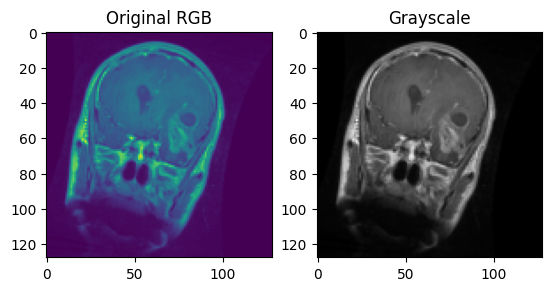

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(images[0])  # Original RGB
plt.title("Original RGB")

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(images[0]), cmap='gray')  # Grayscale
plt.title("Grayscale")
plt.show()

Segmentation

In [ ]:
def segment_brain_tumor_refined(images):
    tumor_masks = []
    tumor_areas = []

    for image in images:

        if image.dtype != np.uint8:
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
            image = np.uint8(image)

        # Preprocessing
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
        blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

        # Thresholding
        _, otsu_mask = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        lower_intensity = 200
        upper_intensity = 300
        intensity_mask = cv2.inRange(blurred_image, lower_intensity, upper_intensity)
        combined_mask = cv2.bitwise_and(otsu_mask, intensity_mask)

        # Morphological Operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
        cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

        # Region Filtering
        contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        tumor_mask = np.zeros_like(image)
        image_area = image.shape[0] * image.shape[1]
        min_area_threshold = image_area * 0.001
        max_area_threshold = image_area * 0.5

        for contour in contours:
            contour_area = cv2.contourArea(contour)
            if min_area_threshold < contour_area < max_area_threshold:
                cv2.drawContours(tumor_mask, [contour], -1, 255, thickness=cv2.FILLED)

        tumor_area = np.sum(tumor_mask == 255)

        tumor_masks.append(tumor_mask)
        tumor_areas.append(tumor_area)

    return tumor_masks, tumor_areas

Overlays

In [ ]:
def create_overlay_images(images, tumor_masks):

    overlays = []
    for image, tumor_mask in zip(images, tumor_masks):
        # Normalize MRI image to 8-bit
        normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
        normalized_image = (normalized_image * 255).astype(np.uint8)

        # Convert grayscale MRI image to 3-channel (RGB) for overlay
        normalized_image_rgb = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

        # Create color overlay from tumor mask
        colored_mask = cv2.applyColorMap(tumor_mask.astype(np.uint8), cv2.COLORMAP_JET)

        # Combine normalized image and color mask
        overlay = cv2.addWeighted(normalized_image_rgb, 0.7, colored_mask, 0.3, 0)
        overlays.append(overlay)

    return overlays


def display_sample_overlays(images, tumor_masks, overlays):

    for i in range(min(5, len(images))):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Tumor Mask")
        plt.imshow(tumor_masks[i], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(overlays[i], cmap="gray")
        plt.axis("off")

        plt.show()

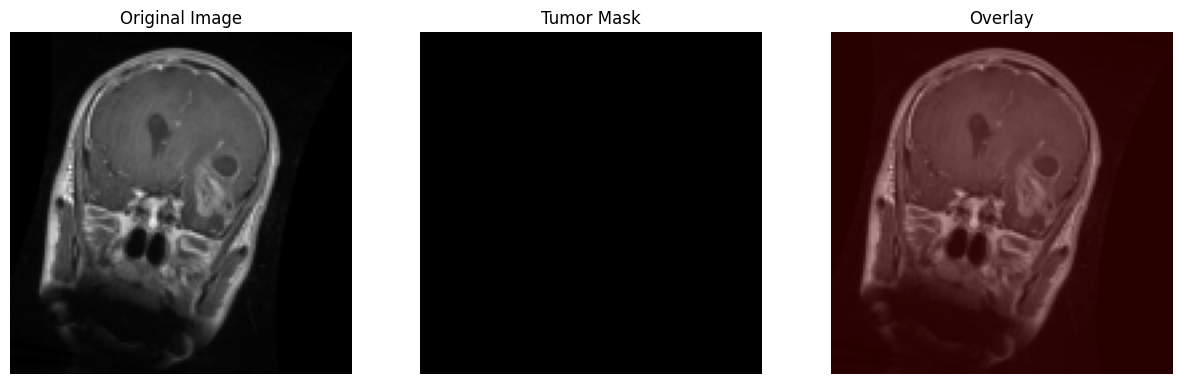

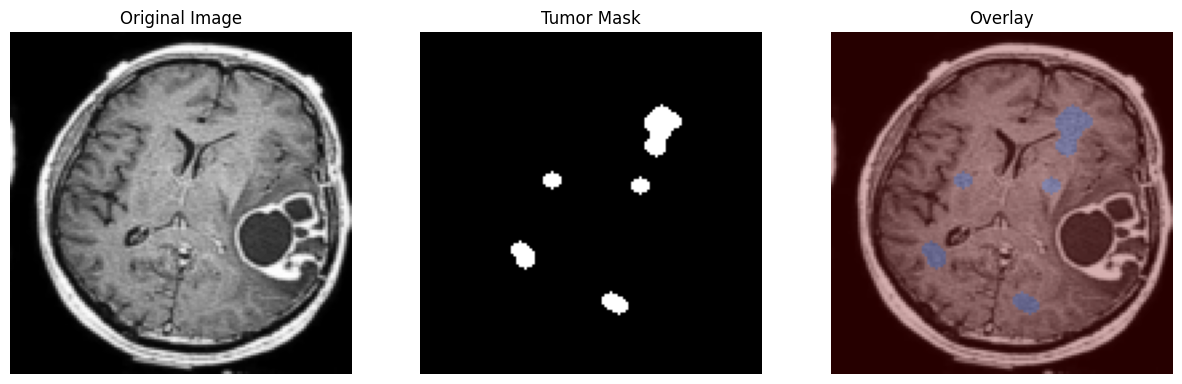

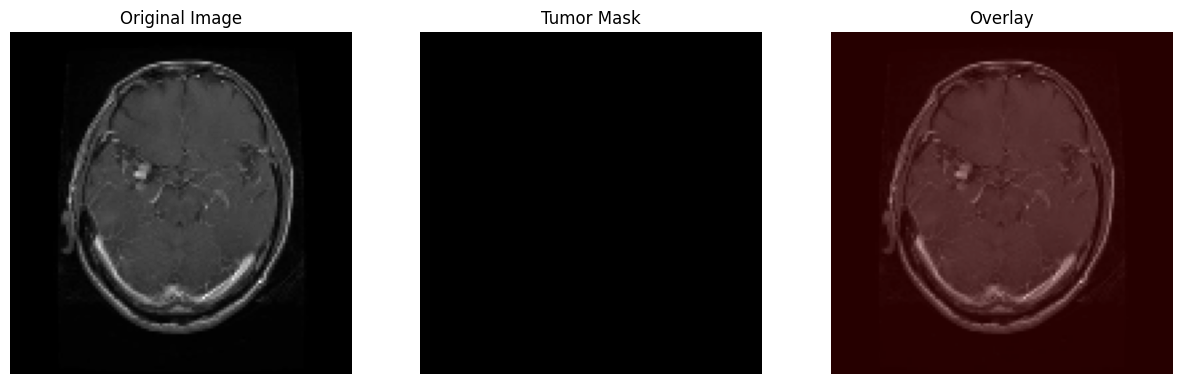

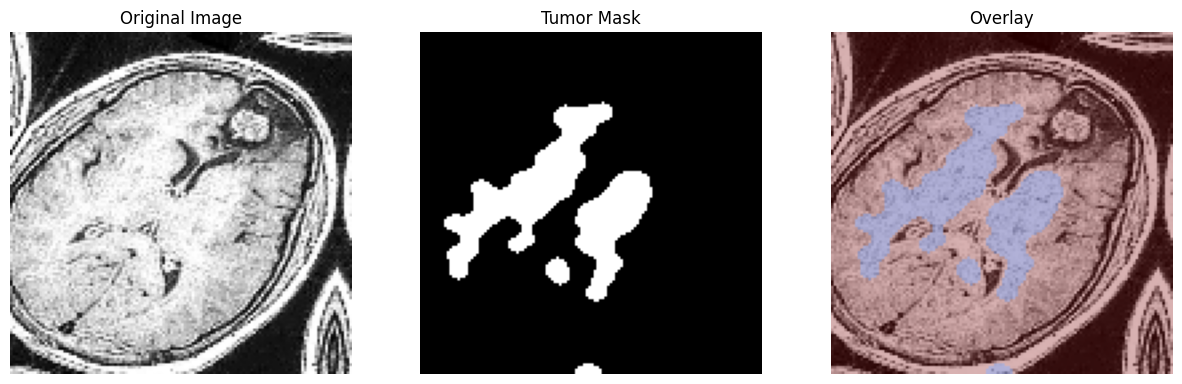

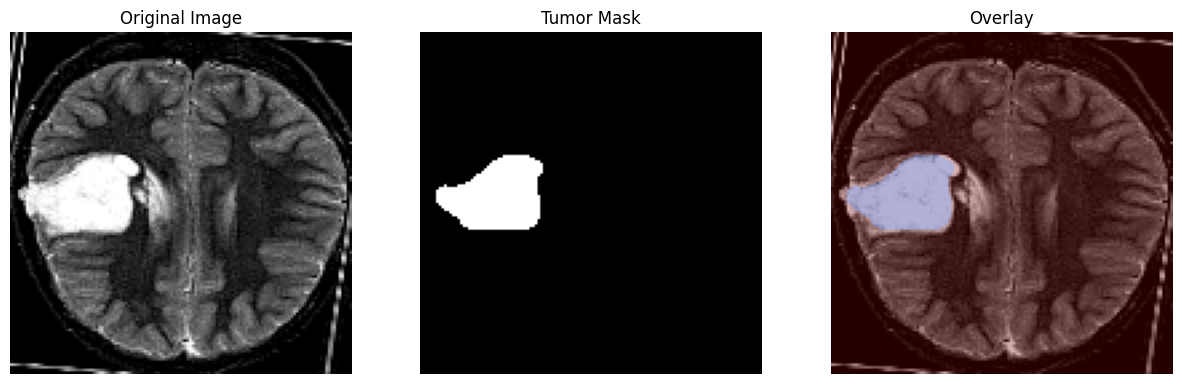

In [ ]:
tumor_masks, tumor_areas = segment_brain_tumor_refined(images)

overlays = create_overlay_images(images, tumor_masks)

display_sample_overlays(images, tumor_masks, overlays)

Dataset split 60:20:20

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(overlays, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (7455, 128, 128, 3), (7455,)
Validation data shape: (2485, 128, 128, 3), (2485,)
Test data shape: (2486, 128, 128, 3), (2486,)


Inception CNN

In [ ]:
def inception_module(x, filters):
    # Filters for each path
    f1, f3r, f3, f5r, f5, pool_proj = filters

    # Path 1: 1x1 Convolution
    path1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    # Path 2: 1x1 Convolution followed by 3x3 Convolution
    path2 = Conv2D(f3r, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

    # Path 3: 1x1 Convolution followed by 5x5 Convolution
    path3 = Conv2D(f5r, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

    # Path 4: 3x3 MaxPooling followed by 1x1 Convolution
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(path4)

    # Concatenate all paths
    output = concatenate([path1, path2, path3, path4], axis=-1)
    return output

def build_inception_cnn():

    input_layer = Input(shape=(128, 128, 3))

    x = Conv2D(32, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = inception_module(x, [16, 32, 64, 128, 64, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(2, activation='sigmoid')(x)

    model = Model(inputs = input_layer, outputs=output_layer)
    return model

model = build_inception_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      1,056 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      4,224 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │        528 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    204,864 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      1,056 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 176)              │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     22,656 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │      5,664 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 176)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     22,656 │ concatenate[0][0] │
│                     │ 128)              │            │                 

 Total params: 32,053,586 (122.27 MB)

 Trainable params: 32,053,586 (122.27 MB)

 Non-trainable params: 0 (0.00 B)

Accuracy and Loss graph

In [ ]:
def plot_accuracy_loss(history):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Confusion Matrix

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

One-hot encoding

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=2)
y_val_encoded = to_categorical(y_val, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

Compile and train

In [ ]:
cnn_model = build_inception_cnn()

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=30, batch_size=32)

val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val_encoded, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_acc = cnn_model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 181s 753ms/step - accuracy: 0.6019 - loss: 67.0289 - val_accuracy: 0.7642 - val_loss: 0.5678
Epoch 2/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 171s 733ms/step - accuracy: 0.7180 - loss: 0.5721 - val_accuracy: 0.8237 - val_loss: 0.4381
Epoch 3/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 169s 725ms/step - accuracy: 0.8021 - loss: 0.4896 - val_accuracy: 0.8592 - val_loss: 0.3744
Epoch 4/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 169s 727ms/step - accuracy: 0.8334 - loss: 0.3949 - val_accuracy: 0.8740 - val_loss: 0.3298
Epoch 5/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 170s 730ms/step - accuracy: 0.8496 - loss: 0.3598 - val_accuracy: 0.8958 - val_loss: 0.2841
Epoch 6/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 168s 720ms/step - accuracy: 0.8533 - loss: 0.3367 - val_accuracy: 0.9030 - val_loss: 0.2300
Epoch 7/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 165s 708ms/step - accuracy: 0.8778 - loss: 0.2933 - val_accuracy: 0.9111 - val_loss: 0.2433
Epoch 8/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 165s 707ms/step - accuracy: 0.8775 

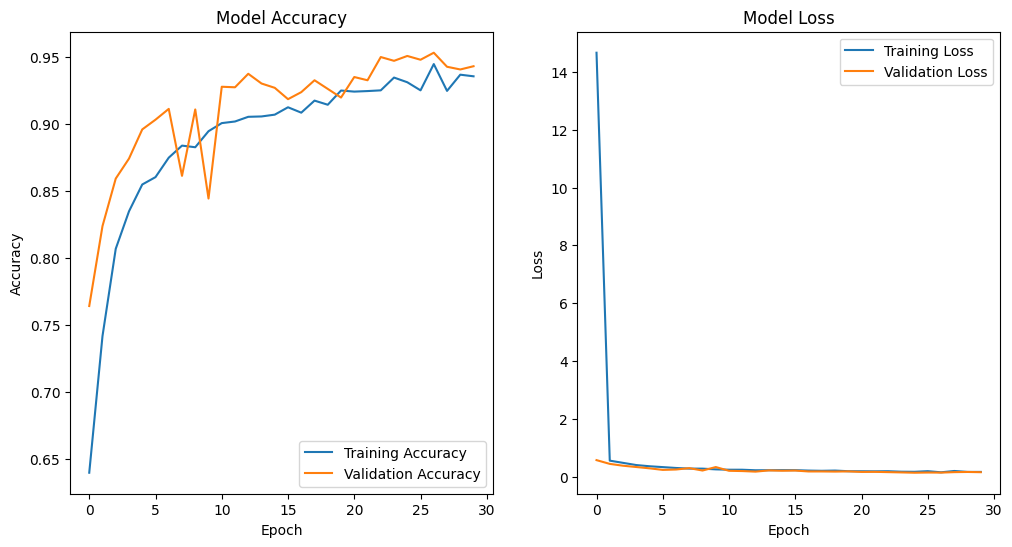

In [ ]:
plot_accuracy_loss(history)

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step


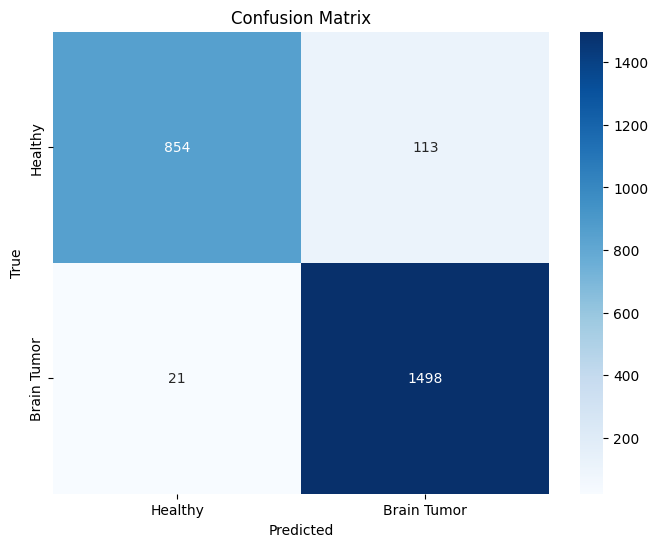

In [ ]:
plot_confusion_matrix(cnn_model, X_test, y_test_encoded)